In [20]:
import io
import pickle
import time
import numpy as np
import random
import sys
import time
import copy
import re
import tensorflow as tf

In [2]:
!pip install levenshtein
from Levenshtein import distance as levenshtein_distance

     |████████████████████████████████| 163kB 5.2MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/transformer/' 

Mounted at /content/gdrive


## ATTENTION

In [4]:

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention,
                                        perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights


## EVALUATE

In [16]:
def sampling(k, predictions, prev_pred, space, syl, start):
    def generation(temp):
        top_k_id, top_k_prob = (tf.nn.top_k(predictions, k=k)[1]).numpy()[0][0], \
                               (tf.nn.top_k(predictions, k=k)[0]).numpy()[0][0]
        top_k_prob = top_k_prob ** temp
        prob_sum = sum(top_k_prob)
        r = random.random() * prob_sum
        j = 0
        while True:
            if r - top_k_prob[j] <= 0:
                return tf.cast(tf.convert_to_tensor([[top_k_id[j]]]), tf.int64)
            r -= top_k_prob[j]
            j += 1

    if len(prev_pred) > 1 and prev_pred[-2] == space and prev_pred[-1] == syl:
        prediction_id = generation(3)
    elif len(prev_pred) > 1 and prev_pred[-2] == start and prev_pred[-1] == syl:
        prediction_id = generation(-3)
    else:
        prediction_id = tf.argmax(predictions, axis=-1)
    return prediction_id


def evaluate(sentence, two_way_X, two_way_y, max_length=1000):
    encoder_input = tf.cast(tf.convert_to_tensor([tokenize(two_way_X, sentence)]), tf.int64)

    t_init, t_end = two_way_y.get('<t_init>'), two_way_y.get('<t_end>')
    start, end = two_way_y.get('<start>'), two_way_y.get('<end>')
    space = tf.cast(tf.convert_to_tensor([two_way_y.get('<s>')]), tf.int64)
    syl = tf.cast(tf.convert_to_tensor([two_way_y.get('<syl>')]), tf.int64)
    output = tf.convert_to_tensor([t_init])
    output = tf.expand_dims(output, 0)
    output = tf.cast(output, tf.int64)

    prev_pred = [t_init]

    for i in range(max_length):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)
        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input,
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)
        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = sampling(10, predictions, prev_pred, space, syl, start)

        prev_pred.append(predicted_id)
        output = tf.concat([output, predicted_id], axis=-1)
        # return the result if the predicted_id is equal to the end token
        if predicted_id == t_end:
            break
    # output.shape (1, tokens)
    text = detokenize(two_way_y, output)
    return text, attention_weights


def evaluate_test(X_test, y_test, two_way_X, two_way_y):
    print(len(X_test))
    distances = []
    for query_sent, true_sent in zip(X_test[30:50], y_test[30:50]):
        pred_text, attention_w = evaluate(query_sent, two_way_X, two_way_y)
        pred_text = make_human_understandable(pred_text)
        true_sent = make_human_understandable(true_sent)
        print(f"pred: {pred_text}\norig: {true_sent}")
        lev = levenshtein_distance(pred_text, true_sent)
        lower = abs(len(pred_text) - len(true_sent))
        upper = max(len(pred_text), len(true_sent))
        distances.append((lev - lower) / (upper - lower))
    print(1 - np.mean(distances))

# BEAM SEARFCH

In [21]:

N_BEAM = 2
K = 10
TEMP = 1


def sampling_flows(flows_array):
    all_flows = copy.deepcopy(flows_array)
    drawn_flows = []
    for _ in range(N_BEAM):
        top_k_prob = [f.prob for f in all_flows]
        top_k_prob = np.array([e if e > 0 else 0.05 for e in top_k_prob])
        top_k_prob = top_k_prob ** TEMP
        prob_sum = sum(top_k_prob)
        r = random.random() * prob_sum
        j = 0
        while True:
            if r - top_k_prob[j] <= 0:
                drawn_flows.append(all_flows[j])
                all_flows.pop(j)
                break
            r -= top_k_prob[j]
            j += 1
    return drawn_flows


def next_predictions(encoder_input, output, k, argmax):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)
    predictions, attention_weights = transformer(encoder_input,
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)
    if not argmax:
        top_k_id_, top_k_prob_ = (tf.nn.top_k(predictions, k=k)[1]).numpy()[0][0], \
                                 (tf.nn.top_k(predictions, k=k)[0]).numpy()[0][0]
        return top_k_id_, top_k_prob_
    else:
        return tf.argmax(predictions, axis=-1)


class Flow:
    def __init__(self, init, prob):
        self.output = init
        self.prob = prob


def beam_search(sentence, two_way_X, two_way_y, max_length=1000):
    encoder_input = tf.cast(tf.convert_to_tensor([tokenize(two_way_X, sentence, X=True)]), tf.int64)
    t_init, t_end = two_way_y.get('<t_init>'), two_way_y.get('<t_end>')
    start, end = two_way_y.get('<start>'), two_way_y.get('<end>')
    space = tf.cast(tf.convert_to_tensor([two_way_y.get('<s>')]), tf.int64)
    syl = tf.cast(tf.convert_to_tensor([two_way_y.get('<syl>')]), tf.int64)
    output = tf.convert_to_tensor([t_init])
    output = tf.expand_dims(output, 0)
    output = tf.cast(output, tf.int64)

    flows_array = [Flow(output, 1)]
    best_flows = []
    for u in range(max_length):
        if False and u % 11 == 0:
            print("Generazione sillaba: " + str(u))
        new_flow_array = []
        for e in flows_array:
            prev_pred = e.output.numpy().flatten()
            if (len(prev_pred) > 1 and prev_pred[-2] == space and prev_pred[-1] == syl) or \
                    (len(prev_pred) > 1 and prev_pred[-2] == start and prev_pred[-1] == syl):
                top_k_id, top_k_prob = next_predictions(encoder_input, e.output, k=K, argmax=False)
                for i in range(len(top_k_id)):
                    new_out = tf.concat(
                        [(copy.deepcopy(e)).output, tf.cast(tf.convert_to_tensor([[top_k_id[i]]]), tf.int64)], axis=-1)
                    new_flow_array.append(Flow(new_out, top_k_prob[i] * e.prob))
            else:
                new_out = tf.concat(
                    [(copy.deepcopy(e)).output, next_predictions(encoder_input, e.output, k=K, argmax=True)], axis=-1)
                new_flow_array.append(Flow(new_out, e.prob))

        flows_array = new_flow_array
        # flows_array = sorted(flows_array, key=lambda f: f.prob, reverse=True)[:N_BEAM]
        if len(flows_array) > N_BEAM:
            flows_array = sampling_flows(flows_array)

        to_pop = []
        for j, flow in enumerate(flows_array):
            if flow.output.numpy().flatten()[-1] == t_end:
                best_flows.append(flow)
                to_pop.append(flow)
        [flows_array.remove(p) for p in to_pop]
        if len(best_flows) == N_BEAM:
            result = (max(best_flows, key=lambda f: f.prob)).output
            text = detokenize(two_way_y, result)
            return text


# ENCODER DECODER

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        return out3, attn_weights_block1, attn_weights_block2


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding,
                                                self.d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]
        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x  # (batch_size, input_seq_len, d_model)


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i + 1}_block1'] = block1
            attention_weights[f'decoder_layer{i + 1}_block2'] = block2
        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights


# TRANSFORMER TOOLS

In [7]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='gelu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])


def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


def create_masks(inp, tar):
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    # Used in the 2nd attention block in the decoder.
    # This padding mask is used to mask the encoder outputs.
    dec_padding_mask = create_padding_mask(inp)
    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return enc_padding_mask, combined_mask, dec_padding_mask


# TRANSFORMER CLASS

In [8]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        self.tokenizer = Encoder(num_layers, d_model, num_heads, dff,
                                 input_vocab_size, pe_input, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                               target_vocab_size, pe_target, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

# ENCODE TOKENIZE \& PERSONAL TOOLS

In [9]:
def encode_dataset(X, y):
    """
        Creates integer encoded version of the dataset.
    """
    encoded_X = TwoWay()
    encoded_set = []
    for row in X:
        tmp_row = re.sub(r'<start>|<end>|<syl>', r'', row)
        [[encoded_set.append(c) for c in w] for w in tmp_row.split('<s>')]
    encoded_set += ['<start>', '<end>', '<s>', '<t_init>', '<t_end>']
    encoded_set = set(encoded_set)
    [encoded_X.add(i + 1, w) for i, w in enumerate(encoded_set)]
    with open('gdrive/MyDrive/transformer/resources/encoded_X.pickle', 'wb') as handle:
        pickle.dump(encoded_X, handle, protocol=pickle.HIGHEST_PROTOCOL)

    encoded_y = TwoWay()
    encoded_set = []
    for row in y:
        tmp_row = re.sub(r'<syl>', r'<s>', row)
        tmp_row = re.sub(r'<start>|<end>|<c>', r'', tmp_row)
        [encoded_set.append(w) for w in tmp_row.split('<s>')]
    encoded_set += ['<syl>', '<s>', '<start>', '<end>', '<t_init>', '<t_end>', '<c>']
    encoded_set = set(encoded_set)
    encoded_set.remove("")
    [encoded_y.add(i + 1, w) for i, w in enumerate(encoded_set)]
    with open('gdrive/MyDrive/transformer/resources/encoded_y.pickle', 'wb') as handle:
        pickle.dump(encoded_y, handle, protocol=pickle.HIGHEST_PROTOCOL)

    print("Data saved successfully!")


def tokenize(two_way, line, X):
    spaced_line = re.sub(r'<', r' <', line)
    spaced_line = re.sub(r'>', r'> ', spaced_line)
    spaced_line = re.sub(r'^ | $', r'', spaced_line)
    spaced_line = re.sub(r'[ ]+', r' ', spaced_line)
    spaced_line = spaced_line.split(' ')
    while True:
        try:
            spaced_line.remove('')
        except ValueError:
            break

    if X: 
        tok_X = []
        for w in spaced_line:
            if w in ['<start>', '<end>', '<s>', '<t_init>', '<t_end>', '<c>']:
                tok_X.append(two_way.get(w))
            else:
                [tok_X.append(two_way.get(c)) for c in w]
        return tok_X
    else:
        return [two_way.get(e) for e in spaced_line]


def detokenize(two_way, line):
    sentence = [two_way.get(e.numpy()) for e in line[0]]
    return ''.join(sentence)


def detokenize_(two_way, line):
    sentence = [two_way.get(e) for e in line]
    return ''.join(sentence)


def make_human_understandable(sentence, keep_syl=True):
    sentence = re.sub(r'<start>|<t_init>|<t_end>|<end>', r'', sentence)
    if keep_syl:
        sentence = re.sub(r'<syl>', r'|', sentence)
    else:
        sentence = re.sub(r'<syl>', r'', sentence)
    sentence = re.sub(r'<s>', r' ', sentence)
    return sentence


def tokenize_pairs(X, y):
    sliding_window = 6
    X_tok = []
    y_tok = []
    for i in range(len(X)):
        next_to_check = ''
        for s in X[i:i + sliding_window + 3]:
            next_to_check += s
        if not re.search(r'<canto>', next_to_check):
            terz = [tokenize(two_way_X, '<t_init>', X=True)[0]]
            terz_y = [tokenize(two_way_y, '<t_init>', X=False)[0]]
            for k in range(sliding_window):
                if (k % 3 == 0) and (k > 0):
                    terz += tokenize(two_way_X, '<t_end>', X=True)
                    terz += tokenize(two_way_X, '<t_init>',X=True)
                terz += (tokenize(two_way_X, X[i + k], X=True))

            terz += tokenize(two_way_X, '<t_end>', X=True)
            for j in range(3):
                terz_y += (tokenize(two_way_y, y[i + j + sliding_window], X=False))
            terz_y += tokenize(two_way_y, '<t_end>', X=False)
            X_tok.append(terz)
            y_tok.append(terz_y)

    return X_tok, y_tok


def make_batches(X_y_tok, batch_size):
    batches = []
    X_tok, y_tok = X_y_tok
    for i in range(0, len(X_tok), batch_size):
        if (batch_size + i) < len(X_tok):
            batches.append((tf.cast(tf.ragged.constant(X_tok[i:i + batch_size]), tf.int64).to_tensor(),
                            (tf.cast(tf.ragged.constant(y_tok[i:i + batch_size]), tf.int64).to_tensor())))
        else:
            break
        # TODO: use the whole dataset
    return batches

# TRANSFORMER TRAINING

In [10]:
!ls gdrive/MyDrive/transformer/

checkpoints  resources	training_data


In [11]:
class TwoWay:
    def __init__(self):
        self.d = {}

    def add(self, k, v):
        self.d[k] = v
        self.d[v] = k

    def remove(self, k):
        self.d.pop(self.d.pop(k))

    def get(self, k):
        return self.d[k]


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)



# INITIALIZERS

X = np.loadtxt("gdrive/MyDrive/transformer/resources/X.csv", dtype=str, delimiter=',', encoding='utf-8')
y = np.loadtxt("gdrive/MyDrive/transformer/resources/y.csv", dtype=str, delimiter=',', encoding='utf-8')
X_val = np.loadtxt("gdrive/MyDrive/transformer/resources/X_val.csv", dtype=str, delimiter=',', encoding='utf-8')
y_val = np.loadtxt("gdrive/MyDrive/transformer/resources/y_val.csv", dtype=str, delimiter=',', encoding='utf-8')
X_test = np.loadtxt("gdrive/MyDrive/transformer/resources/X_test.csv", dtype=str, delimiter=',', encoding='utf-8')

# !!!!!!!!!!!!!!!
# encode_dataset(np.hstack((X, X_val)), np.hstack((y, y_val)))

with open('gdrive/MyDrive/transformer/resources/encoded_X.pickle', 'rb') as f:
    two_way_X = pickle.load(f)
with open('gdrive/MyDrive/transformer/resources/encoded_y.pickle', 'rb') as f:
    two_way_y = pickle.load(f)

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]
val_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

'''
ORIGINALS

num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1
'''

EPOCHS = 200
num_layers = 4
d_model = 256
dff = 1024
num_heads = 8
dropout_rate = 0.1

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')
val_accuracy = tf.keras.metrics.Mean(name='val_accuracy')
val_loss = tf.keras.metrics.Mean(name='val_accuracy')

transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(two_way_X.d),
    target_vocab_size=len(two_way_y.d),
    pe_input=500,
    pe_target=500,
    rate=dropout_rate)

checkpoint_path = "gdrive/MyDrive/transformer/checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)
# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')


def get_encoder_emb(two_way_X):
    weights = transformer.tokenizer.embedding.get_weights()[0]
    vocab = two_way_X

    out_v = io.open('gdrive/MyDrive/transformer/training_data/vectors_enc.tsv', 'w', encoding='utf-8')
    out_m = io.open('gdrive/MyDrive/transformer/training_data/metadata_enc.tsv', 'w', encoding='utf-8')
    for index in range(len(vocab.d) // 2):
        if index == 0:
            continue  # skip 0, it's padding.
        vec = weights[index]
        out_v.write('\t'.join([str(x) for x in vec]) + "\n")
        out_m.write(vocab.get(index) + "\n")
    out_v.close()
    out_m.close()

def get_decoder_emb(two_way_y):
    weights = transformer.decoder.embedding.get_weights()[0]
    vocab = two_way_y

    out_v = io.open('gdrive/MyDrive/transformer/training_data/vectors_dec.tsv', 'w', encoding='utf-8')
    out_m = io.open('gdrive/MyDrive/transformer/training_data/metadata_dec.tsv', 'w', encoding='utf-8')
    for index in range(len(vocab.d) // 2):
        if index == 0:
            continue  # skip 0, it's padding.
        vec = weights[index]
        out_v.write('\t'.join([str(x) for x in vec]) + "\n")
        out_m.write(vocab.get(index) + "\n")
    out_v.close()
    out_m.close()

def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


def fit(train_batches, val_batches):
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    for epoch in range(EPOCHS):
        start = time.time()
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        for (batch, (inp, tar)) in enumerate(train_batches):
            train_step(inp, tar)
            inp_val, tar_val = val_batches[batch % len(val_batches)]
            validation_step(inp_val, tar_val)

            if batch % 100 == 0:
                print(
                    f'Epoch {epoch + 1} Batch {batch}'
                    f' - Loss {train_loss.result():.4f}'
                    f' - Accuracy {train_accuracy.result():.4f}'
                    f' - Val Loss {val_loss.result():.4f}'
                    f' - Val Accuracy {val_accuracy.result():.4f}'
                )

                train_accuracies.append(train_accuracy.result())
                val_accuracies.append(val_accuracy.result())
                train_losses.append(train_loss.result())
                val_losses.append(val_loss.result())

                if (epoch + 1) % 8 == 0:
                    ckpt_save_path = ckpt_manager.save()
                    print(f'Saving checkpoint for epoch {epoch + 1} at {ckpt_save_path}')
                    np.save('gdrive/MyDrive/transformer/training_data/train_accuracies.npy', train_accuracies)
                    np.save('gdrive/MyDrive/transformer/training_data/val_accuracies.npy', val_accuracies)
                    np.save('gdrive/MyDrive/transformer/training_data/train_losses.npy', train_losses)
                    np.save('gdrive/MyDrive/transformer/training_data/val_losses.npy', val_losses)

                    get_encoder_emb(two_way_X)
                    get_decoder_emb(two_way_y)

        print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
        print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

    return np.array(train_accuracies), np.array(train_losses), np.array(val_accuracies), np.array(val_losses)


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(inp, tar_inp,
                                     True,
                                     enc_padding_mask,
                                     combined_mask,
                                     dec_padding_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))


@tf.function(input_signature=val_step_signature)
def validation_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    predictions, _ = transformer(inp, tar_inp,
                                 False,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)
    val_loss(loss)
    val_accuracy(accuracy_function(tar_real, predictions))

Latest checkpoint restored!!


# MAIN

In [23]:
print((detokenize_(two_way_X, tokenize_pairs(X, y)[0][0])))
print((detokenize_(two_way_y, tokenize_pairs(X, y)[1][0])))

BATCH_SIZE = 64

train_batches = make_batches(tokenize_pairs(X, y), batch_size=BATCH_SIZE)
val_batches = make_batches(tokenize_pairs(X_val, y_val), batch_size=BATCH_SIZE)


'''
# Saves pkl with new words not in X
with open('gdrive/MyDrive/transformer/resources/encoded_X.pickle', 'wb') as handle:
    pickle.dump(two_way_X, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('gdrive/MyDrive/transformer/resources/encoded_y.pickle', 'wb') as handle:
    pickle.dump(two_way_y, handle, protocol=pickle.HIGHEST_PROTOCOL)'''


# train_accuracies, train_losses, val_accuracies, val_losses = fit(train_batches, val_batches)

def generator(length):
    array_input = list(X_test[0:6])
    last_input_array = []
    for i in range(length):
        if last_input_array:
            [array_input.pop(0) for _ in range(3)]
            for e in last_input_array:
                array_input.append(re.sub(r'<syl>', '', e))
        # from array to text
        text_input = '<t_init>'
        for k, s in enumerate(array_input):
            if (k % 3 == 0) and (k > 0):
                text_input += '<t_end>'
                text_input += '<t_init>'
            text_input += s
        text_input += '<t_end>'
        # end textification
        # last_input, _ = evaluate.evaluate(text_input, two_way_X, two_way_y, max_length=5000)
        text_input = re.sub(r'<c>', r'', text_input)
        last_input = beam_search(text_input, two_way_X, two_way_y, max_length=5000)

        ###
        last_input = re.sub(r'<t_init>|<t_end>', r'', last_input)
        last_input = re.sub(r'<end>', r'<end>+', last_input)
        last_input_array = last_input.split('+')
        for l in last_input_array:
            print(make_human_understandable(l, True))
        print()


generator(10)

<t_init><start>nel<s>mezzo<s>del<s>cammin<s>di<s>nostra<s>vita<s><end><start>mi<s>ritrovai<s>per<s>una<s>selva<s>oscura<s><end><start>ché<s>la<s>diritta<s>via<s>era<s>smarrita<s><end><t_end><t_init><start>ahi<s>quanto<s>a<s>dir<s>qual<s>era<s>è<s>cosa<s>dura<s><end><start>esta<s>selva<s>selvaggia<s>e<s>aspra<s>e<s>forte<s><end><start>che<s>nel<s>pensier<s>rinova<s>la<s>paura<s><end><t_end>
<t_init><start><syl>tan<syl>t'<s>è<s><syl>a<syl>ma<syl>ra<s><syl>che<c><s><syl>po<syl>co<s>è<s><syl>più<s><syl>mor<syl>te<s><end><start><syl>ma<s><syl>per<s><syl>trat<syl>tar<c><s><syl>del<s><syl>ben<s><syl>ch'<s>i'<s><syl>vi<s><syl>tro<syl>vai<s><end><start><syl>di<syl>rò<s><syl>de<s><syl>l'<s>al<syl>tre<c><s><syl>co<syl>se<s><syl>ch'<s>i'<s><syl>v'<s>ho<s><syl>scor<syl>te<s><end><t_end>
|che |po|ran |per<c> |ri|tor|re |di |d' un |con|tro 
|ve|der |la |vo|ce |de<c> |lo |spe|glio |ne|sto 
|che |si |no|ta|ro |non<c> |al|tri|no |quan|to 


|a |que|sta |ve|ra<c> |con|co|min|cia |tras|se 
|poi |si |tor|n

KeyboardInterrupt: ignored

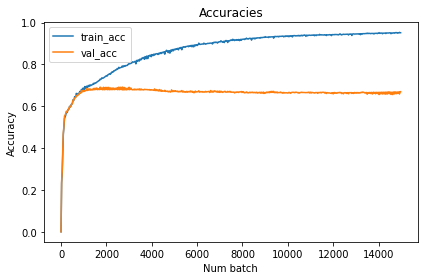

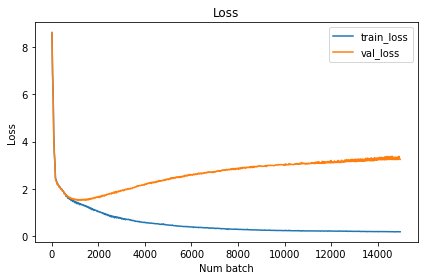

<module 'sys' (built-in)>

In [28]:
import matplotlib.pyplot as plt


def plot_attention_head(in_tokens, translated_tokens, attention):
    translated_tokens = translated_tokens[1:]
    ax = plt.gca()
    ax.matshow(attention)
    ax.set_xticks(range(len(in_tokens)))
    ax.set_yticks(range(len(translated_tokens)))
    labels = [label.decode('utf-8') for label in in_tokens.numpy()]
    ax.set_xticklabels(labels, rotation=90)
    labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
    ax.set_yticklabels(labels)


def print_acc_loss():
    train_accuracies = np.load('gdrive/MyDrive/transformer/training_data/train_accuracies.npy')
    val_accuracies = np.load('gdrive/MyDrive/transformer/training_data/val_accuracies.npy')
    train_losses = np.load('gdrive/MyDrive/transformer/training_data/train_losses.npy')
    val_losses = np.load('gdrive/MyDrive/transformer/training_data/val_losses.npy')

    plt.title("Accuracies")
    plt.plot(range(0, 25 * len(train_accuracies), 25), train_accuracies)
    plt.plot(range(0, 25 * len(train_accuracies), 25), val_accuracies)
    plt.xlabel("Num batch")
    plt.ylabel("Accuracy")
    plt.legend(["train_acc", "val_acc"])
    plt.tight_layout()
    plt.savefig('gdrive/MyDrive/transformer/training_data/Acc_6x_3y_200ep_chars.png')
    plt.show()
    print()

    plt.title("Loss")
    plt.plot(range(0, 25 * len(train_accuracies), 25), train_losses)
    plt.plot(range(0, 25 * len(train_accuracies), 25), val_losses)
    plt.xlabel("Num batch")
    plt.ylabel("Loss")
    plt.legend(["train_loss", "val_loss"])
    plt.tight_layout()
    plt.savefig('gdrive/MyDrive/transformer/training_data/Loss_6x_3y_200ep_chars.png')
    plt.show()


print_acc_loss()
sys

italicized text